## Import packages

In [1]:
import torch
import numpy as np
import time
from scipy.ndimage import distance_transform_edt as distance
from scipy.ndimage import _nd_image

In [2]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Loss Functions

In [3]:
def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss



In [4]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft - gt) ** 2
    s_dtm = seg_dtm ** 2
    g_dtm = gt_dtm ** 2
    dtm = s_dtm + g_dtm
    multipled = torch.einsum('xy, xy->xy', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

# Benchmarks

In [5]:
hd_mean = []
hd_std = []
	
dice_mean = []
dice_std = []
	
hd_GPU_mean = []
hd_GPU_std = []
	
dice_GPU_mean = []
dice_GPU_std = []

hd_times = []
dice_times = []
hd_GPU_times = []
dice_GPU_times = []

In [6]:
for n in range(2,1000,100):
  # HD CPU
  temp_hd_time = []
  for i in range(100): #Samples
    a = []
    for j in range(10): #Evaluations
      x1 = torch.randint(0,2,(n,n))
      tfm1 = torch.from_numpy(distance(x1))
      times1 = time.time()
      hd = hd_loss(x1, x1, tfm1, tfm1)
      a.append(time.time()-times1)
    temp_hd_time.append(torch.mean(torch.FloatTensor(a)))
  hd_times.append(temp_hd_time)

for n in range(2,1000,100):
  # Dice CPU
  temp_dice_time = []
  for i in range(100): #Samples
    b = []
    for j in range(10): #Evaluations
      x2 = torch.randint(0,2,(n,n))
      times2 = time.time()
      dice = dice_loss(x2, x2)
      b.append(time.time()-times2)
    temp_dice_time.append(torch.mean(torch.FloatTensor(b)))
  dice_times.append(temp_dice_time)
  
for n in range(2,1000,100):
  # HD GPU
  temp_hd_GPU_time = []
  for i in range(100): #Samples
    c = []
    for j in range(10): #Evaluations
      x3 = torch.randint(0,2,(n,n)).to(device)
      tfm3 = torch.from_numpy(distance(x3.cpu().numpy())).to(device)
      times3 = time.time()
      hd_gpu = hd_loss(x3, x3, tfm3, tfm3)
      c.append(time.time()-times3)
    temp_hd_GPU_time.append(torch.mean(torch.FloatTensor(c)))
  hd_GPU_times.append(temp_hd_GPU_time)

for n in range(2,1000,100):
  # Dice GPU
  temp_dice_GPU_time = []
  for i in range(100): #Samples
    d = []
    for j in range(10): #Evaluations
      x4 = torch.randint(0,2,(n,n)).to(device)
      times4 = time.time()
      dice_gpu = dice_loss(x4, x4)
      d.append(time.time()-times4)
    temp_dice_GPU_time.append(torch.mean(torch.FloatTensor(d)))
  dice_GPU_times.append(temp_dice_GPU_time)


In [7]:
for i in hd_times:
  hd_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  hd_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [8]:
for i in dice_times:
  dice_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  dice_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [9]:
for i in hd_GPU_times:
  hd_GPU_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  hd_GPU_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [10]:
for i in dice_GPU_times:
  dice_GPU_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  dice_GPU_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

### Save

In [11]:
import pandas as pd

In [12]:
hd_mean = np.array(hd_mean)
dice_mean = np.array(dice_mean)
hd_GPU_mean = np.array(hd_GPU_mean)
dice_GPU_mean = np.array(dice_GPU_mean)
hd_std = np.array(hd_std)
dice_std = np.array(dice_std)
hd_GPU_std = np.array(hd_GPU_std)
dice_GPU_std = np.array(dice_GPU_std)

In [13]:
data = {'hd_mean_cpu_purePython': hd_mean, 'dice_mean_cpu_purePython': dice_mean, 'hd_mean_gpu_purePython': hd_GPU_mean, 'dice_mean_gpu_purePython': dice_GPU_mean, 'hd_std_cpu_purePython': hd_std, 'dice_std_cpu_purePython': dice_std, 'hd_std_gpu_purePython': hd_GPU_std, 'dice_std_gpu_purePython':dice_GPU_std}

In [14]:
dataframe = pd.DataFrame(data)

In [15]:
dataframe.to_csv("G:\molloi-lab\project-distance-transforms\performance\purePython_Loss.csv")

In [16]:
dataframe

,hd_mean_cpu_purePython,dice_mean_cpu_purePython,hd_mean_gpu_purePython,dice_mean_gpu_purePython,hd_std_cpu_purePython,dice_std_cpu_purePython,hd_std_gpu_purePython,dice_std_gpu_purePython
0,0.000047,0.000050,0.001072,0.000191,0.000050,0.000050,0.009433,0.000060
1,0.000115,0.000094,0.000119,0.000189,0.000077,0.000066,0.000174,0.000113
2,0.000287,0.000213,0.000128,0.000177,0.000160,0.000125,0.000115,0.000051
3,0.000483,0.000265,0.000166,0.000171,0.000164,0.000235,0.000166,0.000121
4,0.001793,0.000481,0.000200,0.000233,0.000120,0.000200,0.000107,0.000079
5,0.002723,0.000642,0.000188,0.000238,0.000151,0.000163,0.000111,0.000089
6,0.003748,0.002141,0.000179,0.000251,0.000140,0.000118,0.000132,0.000101
7,0.005004,0.002833,0.000204,0.000241,0.000143,0.000166,0.000117,0.000152
8,0.005887,0.003356,0.000185,0.000238,0.000153,0.000160,0.000109,0.000137
9,0.006971,0.003730,0.000210,0.000277,0.000166,0.000112,0.000126,0.000109


In [17]:
x = [i for i in range(1, 1000, 100)]

In [18]:
import matplotlib.pyplot as plt


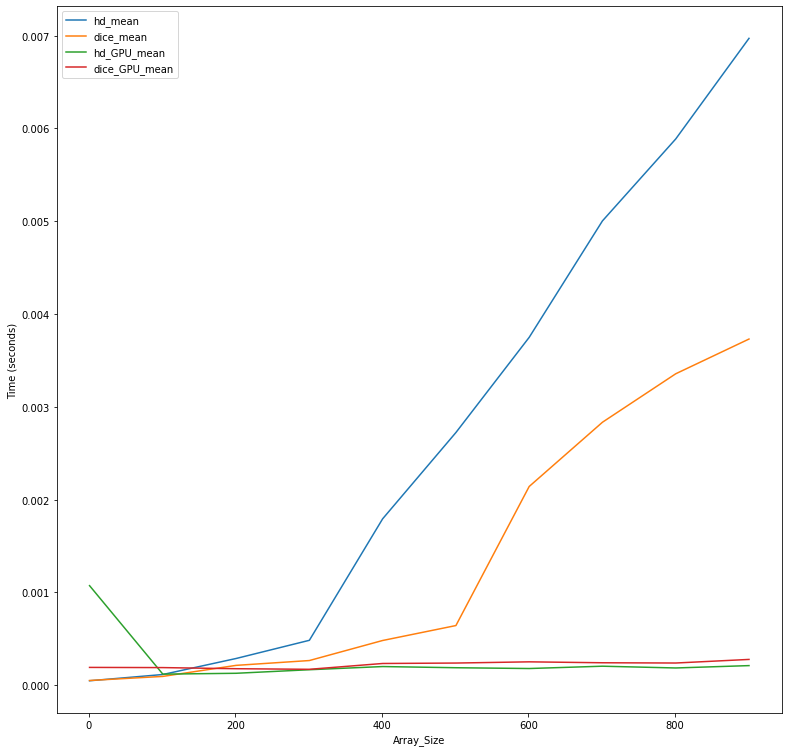

In [20]:
plt.figure(figsize=(13, 13))
plt.plot(x, dataframe['hd_mean_cpu_purePython'], label = 'hd_mean')
plt.plot(x, dataframe['dice_mean_cpu_purePython'], label = 'dice_mean')
plt.plot(x, dataframe['hd_mean_gpu_purePython'], label = 'hd_GPU_mean')
plt.plot(x, dataframe['dice_mean_gpu_purePython'], label = 'dice_GPU_mean')
plt.xlabel('Array_Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()